In [1]:
import pandas as pd
import numpy as np
import alphalens

In [2]:
data = pd.read_csv(r'/home/ibrahim/Desktop/internship_project/data/Price.csv',index_col='Unnamed: 0')

/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
pivotdata = data.pivot_table(values='adjusted_close',index='date',columns='symbol')
pivotdata.index = pd.to_datetime(pivotdata.index)

In [4]:
pivotdata = pivotdata['2000-01-01':]

In [ ]:
def scores_to_alphalens(scores):
    scores_alphalens = scores.unstack()
    scores_alphalens = scores_alphalens.reset_index(level=[0,1])
    scores_alphalens.columns = ['symbol', 'date', 'factor']
    scores_alphalens = scores_alphalens.set_index(['date','symbol'])
    
    return scores_alphalens

In [5]:
def calc_rsi(range1,range2,pivotdata):
    dayrangedreturns = pivotdata.pct_change()
    scores = dayrangedreturns.copy()

    
    def rsi_cal(company):
        
        pos = np.mean(list(filter(lambda x: x >0, company))) 
        neg = np.mean(list(filter(lambda x: x <0, company))) 

        if neg!=0:
            return 100-(100/(1+abs(pos/neg)))
        else:
            return 100.0
    
    scores = scores.rolling(range1,min_periods=range2).apply(rsi_cal,raw=True)
    scores_alphalens = scores.copy()
    
    scores_alphalens = scores_alphalens.unstack()
    scores_alphalens = scores_alphalens.reset_index(level=[0,1])
    scores_alphalens.columns = ['symbol', 'date', 'factor']
    scores_alphalens = scores_alphalens.set_index(['date','symbol'])
    
    return scores_alphalens

In [6]:
scores = calc_rsi(10,8,pivotdata)  

/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [7]:
scores_pivot = pd.pivot_table(scores,values='factor',index='date',columns='symbol')
scores_pivot = scores_pivot[1:]
labeled_scores_pivot = scores_pivot.transform(lambda x: pd.qcut(x,9,labels=list(range(1,10)),duplicates='drop'),axis=1)

In [8]:
scores_alphalens=scores_to_alphalens(labeled_scores_pivot)

In [9]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=scores_alphalens,prices=pivotdata,quantiles=9 ,periods=(1,5,10,20,60,120,240),max_loss=43)

Dropped 44.8% entries from factor data: 35.9% in forward returns computation and 8.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 4300.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,1.0,2.0,1.001446,0.037996,157700,11.235026
2.0,2.0,3.0,2.001349,0.036705,155663,11.089904
3.0,3.0,4.0,3.001993,0.044595,156071,11.118972
4.0,4.0,5.0,4.001690,0.041073,155048,11.046090
5.0,5.0,6.0,5.002596,0.050889,155601,11.085487
6.0,6.0,7.0,6.001059,0.032529,155773,11.097741
7.0,7.0,8.0,7.001419,0.037637,155090,11.049082
8.0,8.0,8.0,8.000000,0.000000,155358,11.068175
9.0,9.0,9.0,9.000000,0.000000,157342,11.209521


Returns Analysis


,1D,5D,10D,20D,60D,120D,240D
Ann. alpha,0.054,0.044,0.035,0.023,0.007,-0.001,-0.005
beta,-0.036,-0.052,-0.045,-0.043,-0.022,-0.014,-0.002
Mean Period Wise Return Top Quantile (bps),5.058,2.214,1.568,0.377,-0.846,-1.364,-1.227
Mean Period Wise Return Bottom Quantile (bps),-4.753,-3.292,-2.843,-2.237,-1.042,-0.622,-0.548
Mean Period Wise Spread (bps),9.812,5.401,4.267,2.511,0.116,-0.769,-0.706


/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


,1D,5D,10D,20D,60D,120D,240D
IC Mean,-0.020,-0.015,-0.014,-0.014,-0.016,-0.017,-0.016
IC Std.,0.081,0.084,0.084,0.082,0.075,0.073,0.072
Risk-Adjusted IC,-0.246,-0.180,-0.170,-0.177,-0.214,-0.240,-0.227
t-stat(IC),NaN,-11.255,-10.635,-11.097,-13.402,-15.014,-14.242
p-value(IC),NaN,0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,NaN,-0.130,-0.225,-0.313,-0.095,-0.106,0.034
IC Kurtosis,NaN,0.237,0.071,0.484,-0.026,0.126,0.176


/home/ibrahim/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,10D,120D,1D,20D,240D,5D,60D
Quantile 1 Mean Turnover,0.880,0.884,0.321,0.880,0.886,0.697,0.884
Quantile 2 Mean Turnover,0.888,0.891,0.577,0.890,0.894,0.823,0.891
Quantile 3 Mean Turnover,0.888,0.890,0.649,0.890,0.892,0.847,0.889
Quantile 4 Mean Turnover,0.883,0.888,0.673,0.884,0.892,0.854,0.887
Quantile 5 Mean Turnover,0.887,0.889,0.688,0.886,0.893,0.861,0.887
Quantile 6 Mean Turnover,0.891,0.893,0.683,0.890,0.892,0.861,0.888
Quantile 7 Mean Turnover,0.889,0.891,0.650,0.890,0.895,0.852,0.890
Quantile 8 Mean Turnover,0.890,0.891,0.566,0.890,0.895,0.820,0.888
Quantile 9 Mean Turnover,0.868,0.882,0.305,0.873,0.888,0.671,0.879


,1D,5D,10D,20D,60D,120D,240D
Mean Factor Rank Autocorrelation,0.842,0.407,0.004,0.006,0.006,0.005,0.001


<Figure size 432x288 with 0 Axes>

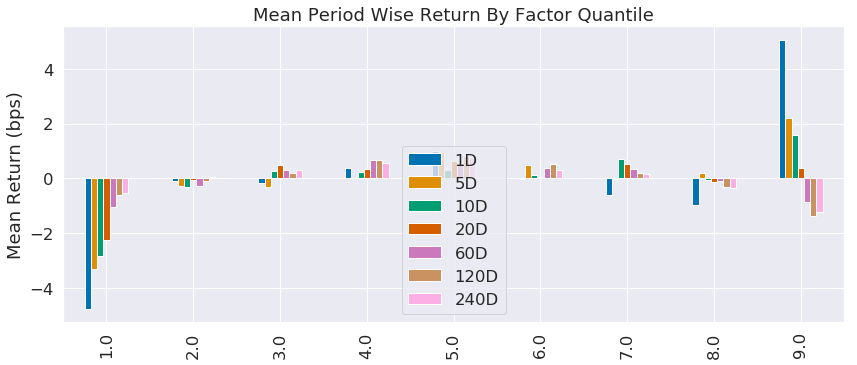

In [10]:
alphalens.tears.create_summary_tear_sheet(factor_data)

In [11]:
sec_scores_alphalens = calc_rsi(60,48,pivotdata)

/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [12]:
scores_pivot = pd.pivot_table(sec_scores_alphalens,values='factor',index='date',columns='symbol')
scores_pivot = scores_pivot[1:]
labeled_scores_pivot = scores_pivot.transform(lambda x: pd.qcut(x,9,labels=list(range(1,10)),duplicates='drop'),axis=1)

In [13]:
sec_scores_alphalens=scores_to_alphalens(labeled_scores_pivot)

In [14]:
sec_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=sec_scores_alphalens,prices=pivotdata,quantiles=9 ,periods=(1,5,10,20,60,120,240),max_loss=44)

Dropped 43.5% entries from factor data: 34.9% in forward returns computation and 8.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 4400.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,1.0,2.0,1.000213,0.014577,159982,11.232932
2.0,2.0,3.0,2.001101,0.033170,157971,11.091732
3.0,3.0,4.0,3.002619,0.051109,158459,11.125996
4.0,4.0,5.0,4.000306,0.017488,156909,11.017165
5.0,5.0,6.0,5.002540,0.050331,158289,11.114060
6.0,6.0,7.0,6.001410,0.037529,158109,11.101422
7.0,7.0,8.0,7.001768,0.042010,157241,11.040476
8.0,8.0,8.0,8.000000,0.000000,157459,11.055783
9.0,9.0,9.0,9.000000,0.000000,159804,11.220434


Returns Analysis


,1D,5D,10D,20D,60D,120D,240D
Ann. alpha,0.010,0.009,0.005,0.002,-0.007,-0.009,-0.010
beta,-0.020,-0.057,-0.070,-0.075,-0.053,-0.053,-0.013
Mean Period Wise Return Top Quantile (bps),0.865,0.207,-0.823,-1.496,-2.230,-2.919,-2.775
Mean Period Wise Return Bottom Quantile (bps),-1.380,-0.383,-0.024,0.240,-0.154,-0.155,-0.739
Mean Period Wise Spread (bps),2.245,0.333,-1.042,-2.008,-2.328,-2.890,-2.203


/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


,1D,5D,10D,20D,60D,120D,240D
IC Mean,-0.025,-0.030,-0.034,-0.039,-0.046,-0.051,-0.044
IC Std.,0.078,0.085,0.088,0.092,0.093,0.088,0.087
Risk-Adjusted IC,-0.326,-0.346,-0.384,-0.421,-0.494,-0.583,-0.506
t-stat(IC),NaN,-21.641,-24.003,-26.362,-30.923,-36.469,-31.671
p-value(IC),NaN,0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,NaN,-0.208,-0.345,-0.443,-0.228,-0.278,0.189
IC Kurtosis,NaN,0.228,0.219,0.301,0.554,0.329,0.246


/home/ibrahim/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,10D,120D,1D,20D,240D,5D,60D
Quantile 1 Mean Turnover,0.398,0.869,0.122,0.554,0.878,0.281,0.874
Quantile 2 Mean Turnover,0.683,0.882,0.292,0.773,0.887,0.566,0.885
Quantile 3 Mean Turnover,0.750,0.884,0.375,0.817,0.887,0.655,0.884
Quantile 4 Mean Turnover,0.774,0.887,0.415,0.833,0.891,0.687,0.885
Quantile 5 Mean Turnover,0.780,0.886,0.420,0.841,0.892,0.692,0.886
Quantile 6 Mean Turnover,0.767,0.887,0.400,0.833,0.894,0.674,0.890
Quantile 7 Mean Turnover,0.733,0.886,0.353,0.812,0.890,0.631,0.885
Quantile 8 Mean Turnover,0.650,0.883,0.267,0.756,0.887,0.528,0.882
Quantile 9 Mean Turnover,0.352,0.851,0.108,0.501,0.864,0.248,0.841


,1D,5D,10D,20D,60D,120D,240D
Mean Factor Rank Autocorrelation,0.967,0.884,0.792,0.623,0.053,0.051,0.044


<Figure size 432x288 with 0 Axes>

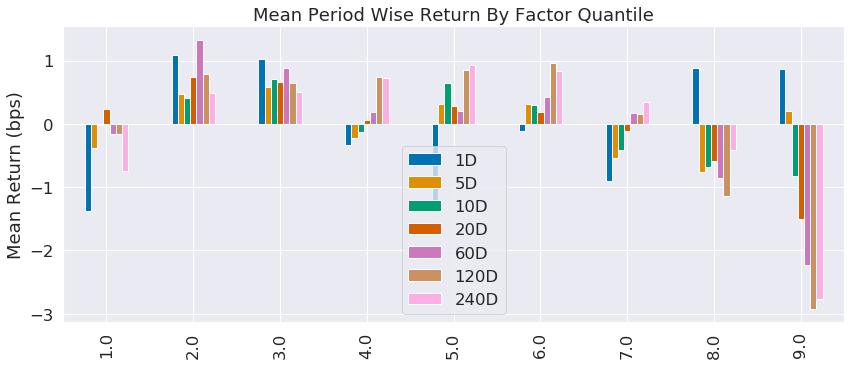

In [15]:
alphalens.tears.create_summary_tear_sheet(sec_factor_data) 

In [6]:
thd_scores_alphalens = calc_rsi(240,192,pivotdata)

/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [7]:
scores_pivot = pd.pivot_table(thd_scores_alphalens,values='factor',index='date',columns='symbol')
scores_pivot = scores_pivot[1:]
labeled_scores_pivot = scores_pivot.transform(lambda x: pd.qcut(x,9,labels=list(range(1,10)),duplicates='drop'),axis=1)

In [8]:
thd_scores_alphalens=scores_to_alphalens(labeled_scores_pivot)

In [9]:
thd_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=thd_scores_alphalens,prices=pivotdata,quantiles=9 ,periods=(1,5,10,20,60,120,240),max_loss=36)

Dropped 41.2% entries from factor data: 35.2% in forward returns computation and 6.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 3600.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,1.0,2.0,1.000588,0.024245,161525,11.227969
2.0,2.0,3.0,2.001040,0.032232,159614,11.095131
3.0,3.0,4.0,3.001731,0.041568,160036,11.124465
4.0,4.0,5.0,4.003282,0.057191,159068,11.057177
5.0,5.0,6.0,5.001421,0.037664,159089,11.058637
6.0,6.0,7.0,6.001669,0.040815,160011,11.122727
7.0,7.0,8.0,7.000630,0.025098,158651,11.028191
8.0,8.0,8.0,8.000000,0.000000,159322,11.074833
9.0,9.0,9.0,9.000000,0.000000,161279,11.210869


Returns Analysis


,1D,5D,10D,20D,60D,120D,240D
Ann. alpha,-0.027,-0.025,-0.024,-0.018,-0.010,-0.001,-0.008
beta,-0.002,-0.026,-0.037,-0.051,-0.042,-0.044,-0.040
Mean Period Wise Return Top Quantile (bps),-2.091,-2.755,-3.111,-2.699,-3.385,-3.456,-4.179
Mean Period Wise Return Bottom Quantile (bps),0.019,0.005,-0.065,-0.245,-1.566,-2.028,-1.573
Mean Period Wise Spread (bps),-2.110,-2.980,-3.271,-2.742,-2.040,-1.604,-2.987


/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


,1D,5D,10D,20D,60D,120D,240D
IC Mean,-0.030,-0.041,-0.047,-0.050,-0.056,-0.059,-0.069
IC Std.,0.076,0.084,0.090,0.094,0.091,0.091,0.090
Risk-Adjusted IC,-0.395,-0.489,-0.519,-0.532,-0.615,-0.649,-0.765
t-stat(IC),NaN,-30.744,-32.658,-33.472,-38.690,-40.792,-48.099
p-value(IC),NaN,0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,NaN,-0.134,-0.231,-0.439,-0.210,-0.198,-0.046
IC Kurtosis,NaN,0.177,0.402,0.440,0.305,0.263,-0.198


/home/ibrahim/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,10D,120D,1D,20D,240D,5D,60D
Quantile 1 Mean Turnover,0.189,0.644,0.059,0.270,0.855,0.133,0.467
Quantile 2 Mean Turnover,0.425,0.805,0.145,0.549,0.870,0.313,0.728
Quantile 3 Mean Turnover,0.518,0.840,0.188,0.637,0.880,0.396,0.779
Quantile 4 Mean Turnover,0.555,0.862,0.211,0.670,0.886,0.433,0.804
Quantile 5 Mean Turnover,0.556,0.857,0.211,0.672,0.885,0.434,0.803
Quantile 6 Mean Turnover,0.538,0.850,0.199,0.658,0.880,0.414,0.798
Quantile 7 Mean Turnover,0.487,0.835,0.175,0.611,0.883,0.369,0.767
Quantile 8 Mean Turnover,0.379,0.796,0.127,0.501,0.872,0.277,0.694
Quantile 9 Mean Turnover,0.158,0.568,0.048,0.227,0.801,0.110,0.403


,1D,5D,10D,20D,60D,120D,240D
Mean Factor Rank Autocorrelation,0.988,0.966,0.944,0.902,0.746,0.536,0.148


<Figure size 432x288 with 0 Axes>

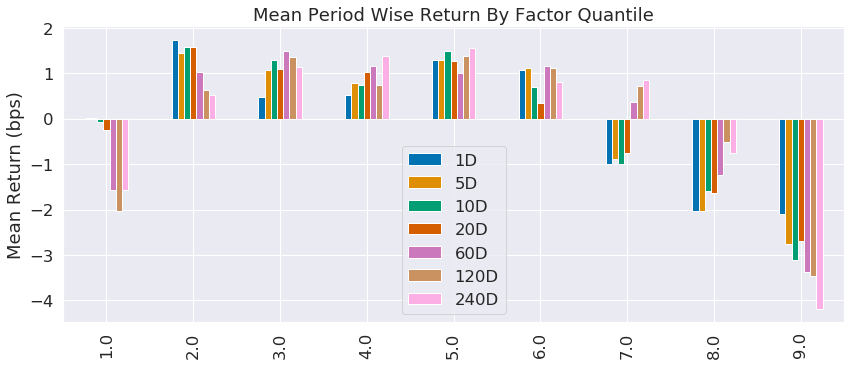

In [10]:
alphalens.tears.create_summary_tear_sheet(thd_factor_data)